# 0. Import statments

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import tensorflow.keras as keras
from google.colab import files
import os
from zipfile import ZipFile
import pathlib
import random
from tensorflow.keras import layers

# 1. Loading the data

In [2]:
# Get the data (10% of 10 food classes from Food101)

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the folder
with ZipFile("10_food_classes_10_percent.zip") as folder:

  folder.extractall()

--2025-12-04 02:14:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 172.253.118.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 8.1s    

2025-12-04 02:14:12 (19.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



# 3. Inspecting the data

In [4]:
# Get the class names

data_dir = pathlib.Path("10_food_classes_10_percent/train") # turning the directory into a path object

class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class names from the sub-directories

pd.DataFrame(data={"meal_name": class_names})

,meal_name
0,chicken_curry
1,chicken_wings
2,fried_rice
3,grilled_salmon
4,hamburger
5,ice_cream
6,pizza
7,ramen
8,steak
9,sushi


In [5]:
def visualize_data(class_name):

    dir = "10_food_classes_10_percent/train/" + class_name

    img_names = random.sample(population=os.listdir(dir), k=3)

    fig, axes = plt.subplots(ncols=3, figsize=(10, 3))

    axes = axes.flatten()

    fig.suptitle(f"{class_name.capitalize()} images", fontsize=15)


    for i in range(len(axes)):

        ax = axes[i]

        image = mpimg.imread(dir + "/" + img_names[i])

        ax.imshow(image)

        ax.axis(False)

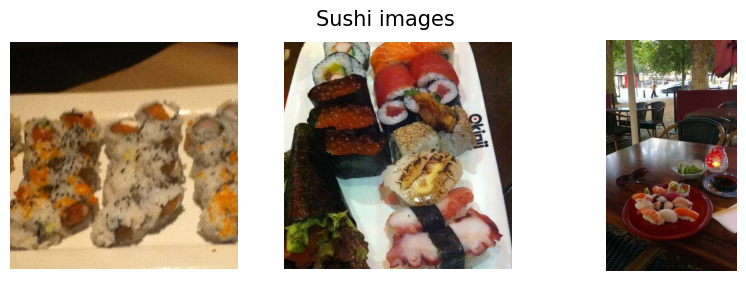

In [6]:
visualize_data(random.choice(class_names)) # I am using a random dish here, but you (TA or professor) can pass in specific dish names

# 4. Creating data loaders (preparing the data)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = [224, 224]
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/test"
test_dir = "10_food_classes_10_percent/train"  # ⚠️ I have switched the test and train dir on purpose here because

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,           # Randomly rotate images up to 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    shear_range=0.2,             # Randomly shear images
    zoom_range=0.2,              # Randomly zoom images
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill in missing pixels with the nearest filled value
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="sparse",
                                               shuffle=True)  # Changed to True for better training

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="sparse",
                                            shuffle=False)


Found 2500 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


# 5. Creating My own Neural Network

In [8]:
# Set the random seed
tf.random.set_seed(42)

# Build an improved CNN model
model_1 = keras.Sequential([
    # Block 1
    keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=[224, 224, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2, padding="valid"),

    # Block 2
    keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),

    # Block 3
    keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),

    # Dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),  # Prevent overfitting
    keras.layers.Dense(10, activation="softmax")
])

# Compile with better optimizer settings
model_1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Add callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),

    # Reduce learning rate when plateauing
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Fit the model with more epochs
history_1 = model_1.fit(
    train_data,
    epochs=50,  # More epochs (early stopping will stop if needed)
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.1541 - loss: 3.1749
Epoch 1: val_accuracy improved from -inf to 0.08800, saving model to best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 54s 576ms/step - accuracy: 0.1544 - loss: 3.1721 - val_accuracy: 0.0880 - val_loss: 2.8122 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2203 - loss: 2.6462
Epoch 2: val_accuracy improved from 0.08800 to 0.09867, saving model to best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 476ms/step - accuracy: 0.2204 - loss: 2.6451 - val_accuracy: 0.0987 - val_loss: 3.1626 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.2389 - loss: 2.4357
Epoch 3: val_accuracy improved from 0.09867 to 0.14267, saving model to best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 477ms/step - accuracy: 0.2390 - loss: 2.4347 - val_accuracy: 0.1427 - val_loss: 2.7292 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step 

In [10]:
# from google.colab import files

# # Download the H5 file
# files.download('best_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

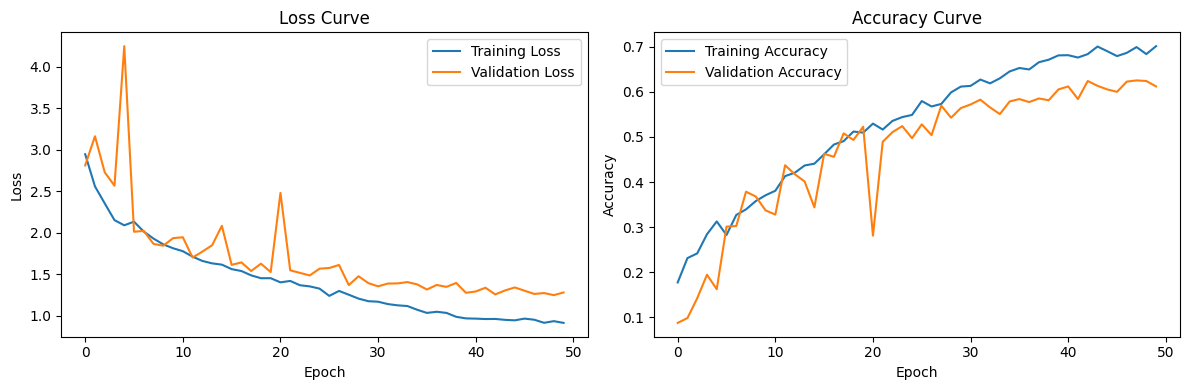

In [11]:
plt.figure(figsize=(12, 4))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()


In [28]:
# Loading my best model
my_best_cnn = tf.keras.models.load_model('best_model.keras')

In [15]:
# Summary of the model
my_best_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 106, 106, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,146,112 (118.81 MB)

 Trainable params: 10,381,738 (39.60 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 20,763,478 (79.21 MB)

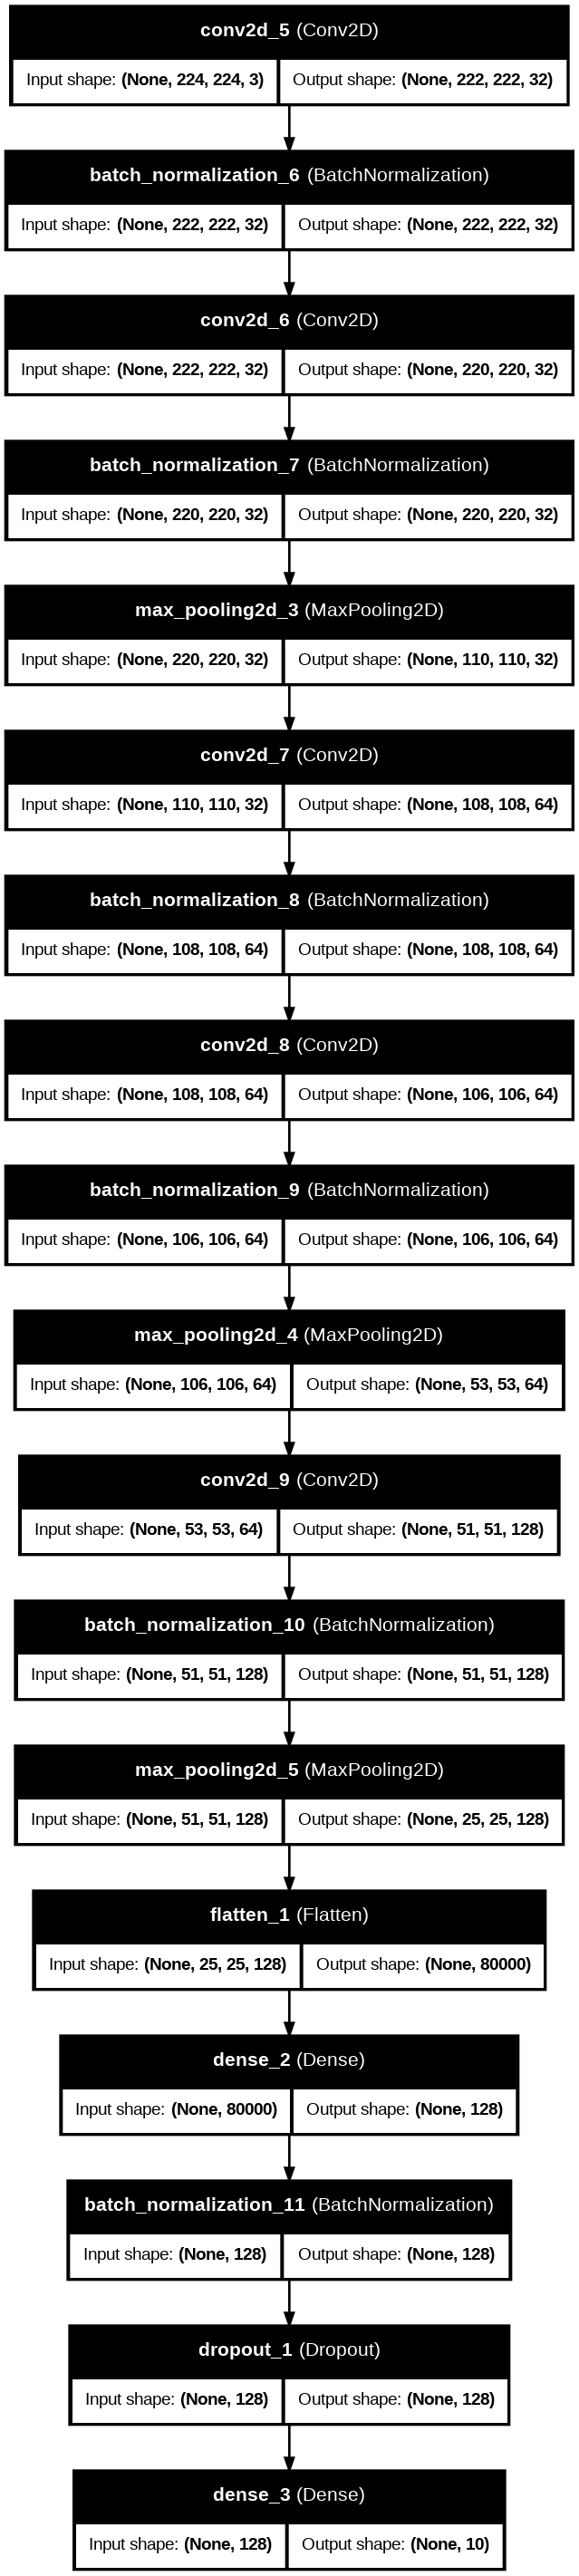

In [17]:
# Visual plot
tf.keras.utils.plot_model(
    my_best_cnn,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # Top to Bottom
    expand_nested=True,
    dpi=96
)


In [29]:
# Evaluate my Model
transfer_learning_results = my_best_cnn.evaluate(test_data)
print(f"\nTrabfer Learning Results:")
print(f"Loss: {transfer_learning_results[0]:.4f}")
print(f"Accuracy: {transfer_learning_results[1]:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.5881 - loss: 1.4315

Trabfer Learning Results:
Loss: 1.2757
Accuracy: 0.6253


# 6. FROZEN FEATURE EXTRACTION

In [10]:
# Load pretrained EfficientNetV2B0 without top classification layer
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,  # not including classification head
    weights="imagenet",  # Using ImageNet pretrained weights
    input_shape=(224, 224, 3),
    include_preprocessing=False # not including processing because my data is already scaled
)

# FREEZE all layers in base model
base_model.trainable = False

print(f"Base model has {len(base_model.layers)} layers")
print(f"All layers frozen: trainable = {base_model.trainable}")

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Base model has 268 layers
All layers frozen: trainable = False


In [11]:
# Building Feature Extraction Only

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# Pass through frozen base model
x = base_model(inputs, training=False)  # training=False for frozen model

# Global Average Pooling to convert to 1D feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Output layer (10 food classes)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create model
frozen_model = tf.keras.Model(inputs, outputs, name="phase1_frozen_features")


# Compile Model
frozen_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


In [12]:
# Print summary of the frozen model
frozen_model.summary()

Model: "phase1_frozen_features"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [13]:
# Create checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_frozen_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Train the model
history_phase1 = frozen_model.fit(
    train_data,
    epochs=50,  # Start with 5 epochs
    validation_data=test_data,
    callbacks=[checkpoint_callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.3445 - loss: 1.9678
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to best_frozen_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 94s 822ms/step - accuracy: 0.3466 - loss: 1.9632 - val_accuracy: 0.7000 - val_loss: 1.1192
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7235 - loss: 1.0221
Epoch 2: val_accuracy improved from 0.70000 to 0.72267, saving model to best_frozen_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 446ms/step - accuracy: 0.7235 - loss: 1.0216 - val_accuracy: 0.7227 - val_loss: 0.9048
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7537 - loss: 0.8379
Epoch 3: val_accuracy improved from 0.72267 to 0.74667, saving model to best_frozen_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.7537 - loss: 0.8376 - val_accuracy: 0.7467 - val_loss: 0.8108
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7821 - loss: 0.7409
Epoch 4: val_accu

In [14]:
# from google.colab import files

# # Download the keras file
# files.download('best_frozen_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

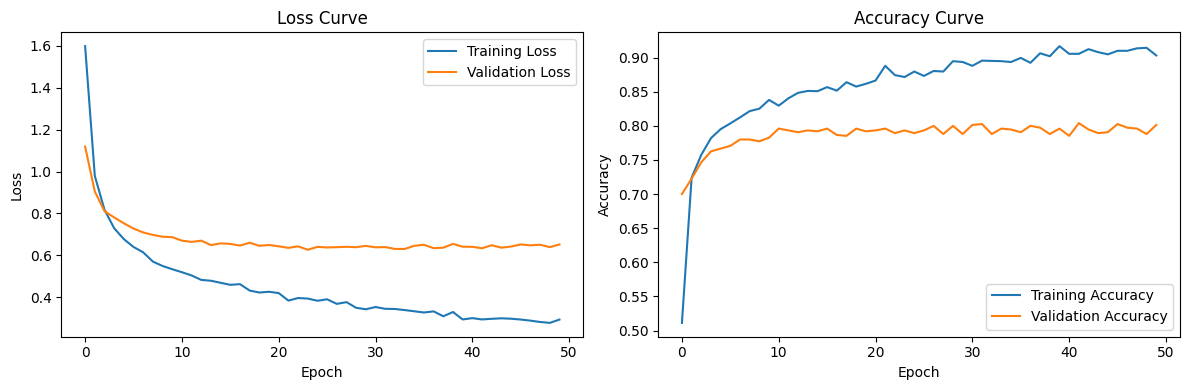

In [15]:
plt.figure(figsize=(12, 4))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history_phase1.history['loss'], label='Training Loss')
plt.plot(history_phase1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(history_phase1.history['accuracy'], label='Training Accuracy')
plt.plot(history_phase1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

In [16]:
best_frozen_model = keras.models.load_model("best_frozen_model.keras")

In [17]:
# Visual plot
tf.keras.utils.plot_model(
    best_frozen_model,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # Top to Bottom
    expand_nested=True,
    dpi=96
)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Evaluate Phase 1 Model
transfer_learning_results = frozen_model.evaluate(test_data)
print(f"\nTrabfer Learning Results:")
print(f"Loss: {transfer_learning_results[0]:.4f}")
print(f"Accuracy: {transfer_learning_results[1]:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7916 - loss: 0.6753

Trabfer Learning Results:
Loss: 0.6517
Accuracy: 0.8013
